Exercise Prompt Hints
- Key step: how to combine movie data into a single string
- Recall TfidfVectorizer expects one string per 'document'
- Transform (into a vectors) the strings using TF-IDF
- Assume the query is always an existing movie in the database
- E.g. query = "Scream 3", then recommend other movies based on this
- Get the TF-IDF representation of Scream 3
- Compute similarity between Scream 3 and all other vectors
- Sort by similarity
- Print out the top 5 closest movies
- Try movies from other genres

In [ ]:
# Gathering data
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

In [ ]:
# creating data frame
import numpy as np
import pandas as pd

df = pd.read_csv('tmdb_5000_movies.csv')
df.head()

In [2]:
# extracting strings example

x = df.iloc[0]
print(x['genres'])
print(x['keywords'])


[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]


In [5]:
# Json dumps
import json

genres_json = json.loads(x['genres'])
# Double join to join multiword genres as single word
genres_string = " ".join(["".join(genre['name'].split()) for genre in genres_json])
print(genres_string)


Action Adventure Fantasy ScienceFiction


In [8]:
# Getting genres and keywords

def genres_keywords_to_string(row):
    
    genres_json = json.loads(row['genres'])
    genres_string = " ".join(["".join(genre['name'].split()) for genre in genres_json])
    
    keywords_json = json.loads(row['keywords'])
    keywords_string = " ".join(["".join(keyword['name'].split()) for keyword in keywords_json])
    
    return "%s %s" % (genres_string, keywords_string)
    


In [9]:
# Create string representation of each movie    

df["movie_string"] = df.apply(genres_keywords_to_string, axis=1)

In [10]:
# Create tfidf vectorizer object
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000) # 2000 most common words in the corpus

In [11]:
# Create tfidf matrix
tfidf_matrix = tfidf.fit_transform(df["movie_string"])
tfidf_matrix.shape

(4803, 2000)

In [14]:
# Create mapping from movie title to index
movie_to_index = pd.Series(df.index, index=df["title"])
movie_to_index.head()

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64

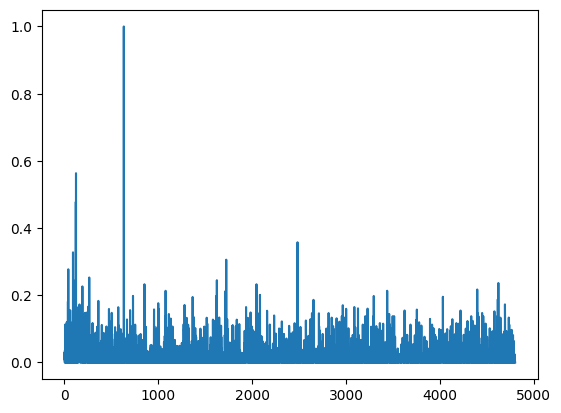

In [20]:
# Testing
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

idx = movie_to_index["The Matrix"]
query = tfidf_matrix[idx]

# Using cosine similarity
scores = cosine_similarity(query, tfidf_matrix)
scores = scores.flatten() # flatten to 1D array
plt.plot(scores)


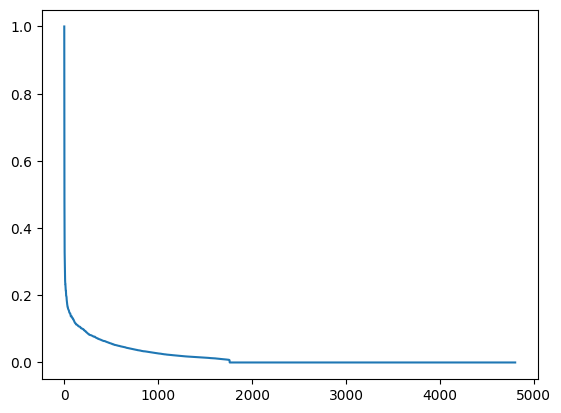

In [21]:
# Sorting the scores descending
plt.plot(scores[(-scores).argsort()])

In [23]:
# Get top 5 similar movies
recommended_idxs = (-scores).argsort()[1:6]
df["title"].iloc[recommended_idxs]

125                    The Matrix Reloaded
123                 The Matrix Revolutions
2484                  The Thirteenth Floor
93      Terminator 3: Rise of the Machines
1725                          Blade Runner
Name: title, dtype: object

In [36]:
# Refactorting

class TfidfRecommender:    
    def __init__(self, df, columns=["genres", "keywords"], max_keywords=2000):
        self.df = df
        self.columns = columns
        self.tfidf = TfidfVectorizer(max_features=max_keywords)
        self.__create_tfidf_matrix()
        self.__create_movie_to_index()
        
    def __columns_to_string(self, row):
        movie_string = ""
        for column in self.columns:
            movie_string += " " + " ".join(["".join(genre['name'].split()) for genre in json.loads(row[column])])
        return movie_string
    
    def __create_movie_strings(self):
        self.df["movie_string"] = self.df.apply(self.__columns_to_string, axis=1)
    
    def __create_tfidf_matrix(self):
        self.__create_movie_strings()
        self.tfidf_matrix = self.tfidf.fit_transform(self.df["movie_string"])
    
    def __create_movie_to_index(self):
        self.movie_to_index = pd.Series(self.df.index, index=self.df["title"])
        
    def __get_movie_index(self, movie_title):
        if type(self.movie_to_index[movie_title]) == pd.Series:
            return self.movie_to_index[movie_title].iloc[0]
        return self.movie_to_index[movie_title]
    
    def __get_query_vector(self, movie_title):
        idx = self.__get_movie_index(movie_title)
        return self.tfidf_matrix[idx]
        
    def get_recommendations(self, movie_title, n_recommendations):
        query_vector = self.__get_query_vector(movie_title)
        
        scores = cosine_similarity(query_vector, self.tfidf_matrix)
        movie_indices = (-scores).flatten().argsort()[1:n_recommendations + 1]
        recommended_movies = [self.df.iloc[i]["title"] for i in movie_indices]
        return recommended_movies
        

In [42]:
# Testing
recommender = TfidfRecommender(df)
print(recommender.get_recommendations("The Matrix", 5))
print(recommender.get_recommendations("The Godfather", 5))
print(recommender.get_recommendations("The Dark Knight Rises", 5))
print(recommender.get_recommendations("Spectre", 5))
print(recommender.get_recommendations("Toy Story", 5))
print(recommender.get_recommendations("Runaway Bride", 5))

['The Matrix Reloaded', 'The Matrix Revolutions', 'The Thirteenth Floor', 'Terminator 3: Rise of the Machines', 'Blade Runner']
['10th & Wolf', "Gangster's Paradise: Jerusalema", 'Down Terrace', 'Black Mass', 'Safe Men']
['The Dark Knight', 'Batman Begins', 'Arbitrage', 'Batman & Robin', 'Kick-Ass 2']
['Quantum of Solace', 'Die Another Day', 'Skyfall', 'Restless', 'Ong Bak 2']
['Toy Story 3', 'Ted', 'Toy Story 2', 'Pinocchio', 'Meet the Deedles']
['House of D', 'My Big Fat Greek Wedding 2', 'It Happened One Night', 'An Education', 'Our Family Wedding']
